In [1]:
import numpy as np
import cv2
import glob

import matplotlib.pyplot as plt

from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

In [2]:
### image info
img_height = 720
img_width = 1280
img_midpoint = img_width // 2
img_size = (img_width, img_height)

### conversions between meters and pixels (for the warped images)
ym_per_px = 30 / (img_height)
xm_per_px = 3.7 / (img_width / 3)

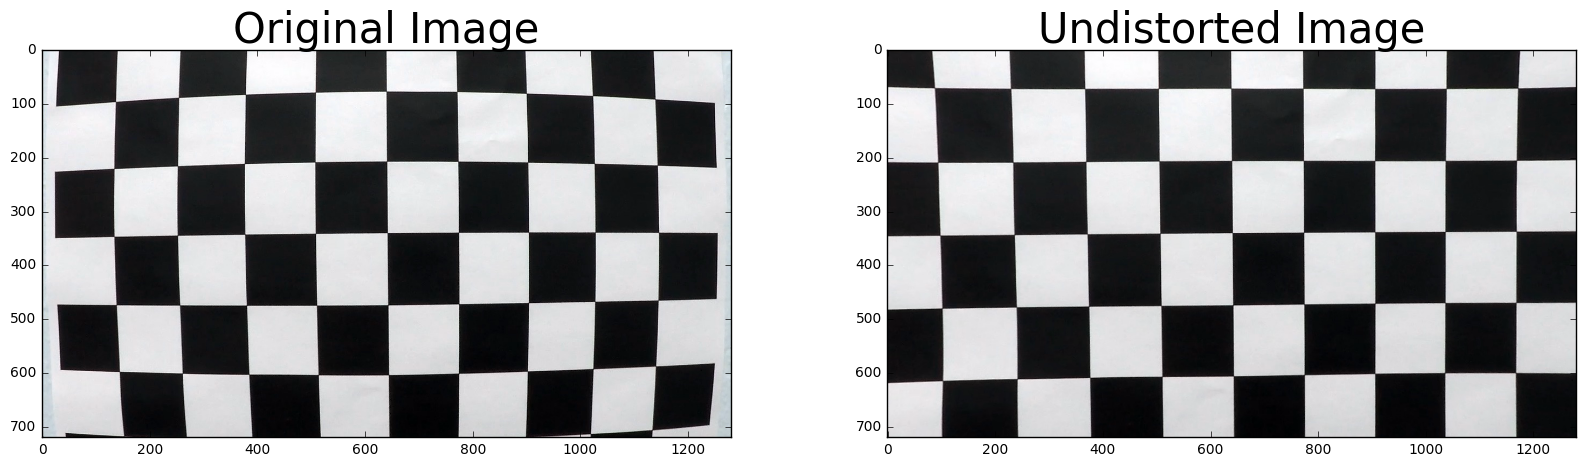

In [3]:
### camera calibration

# read images
cal_images = glob.glob("camera_cal/calibration*.jpg")

# initialize arrays for object points and image points
objp = np.zeros((9*6,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

objpoints = []
imgpoints = []

# loop through images, find chessboard corners, and add corresponding image points and object points to arrays
for idx, fname in enumerate(cal_images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
    
    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)

# calibrate camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

# define function to undistort images, using coefficients found from camera calibration
def undistort_image(image):
    undist_image = cv2.undistort(image, mtx, dist, None, mtx)
    
    return undist_image

# show distorted and undistorted version of same image
orig_cal_img = cv2.imread(cal_images[0])
undist_cal_img = undistort_image(orig_cal_img)

fig = plt.figure(figsize=(20, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(orig_cal_img)
ax1.set_title("Original Image", fontsize=30)

ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(undist_cal_img)
ax2.set_title("Undistorted Image", fontsize=30)

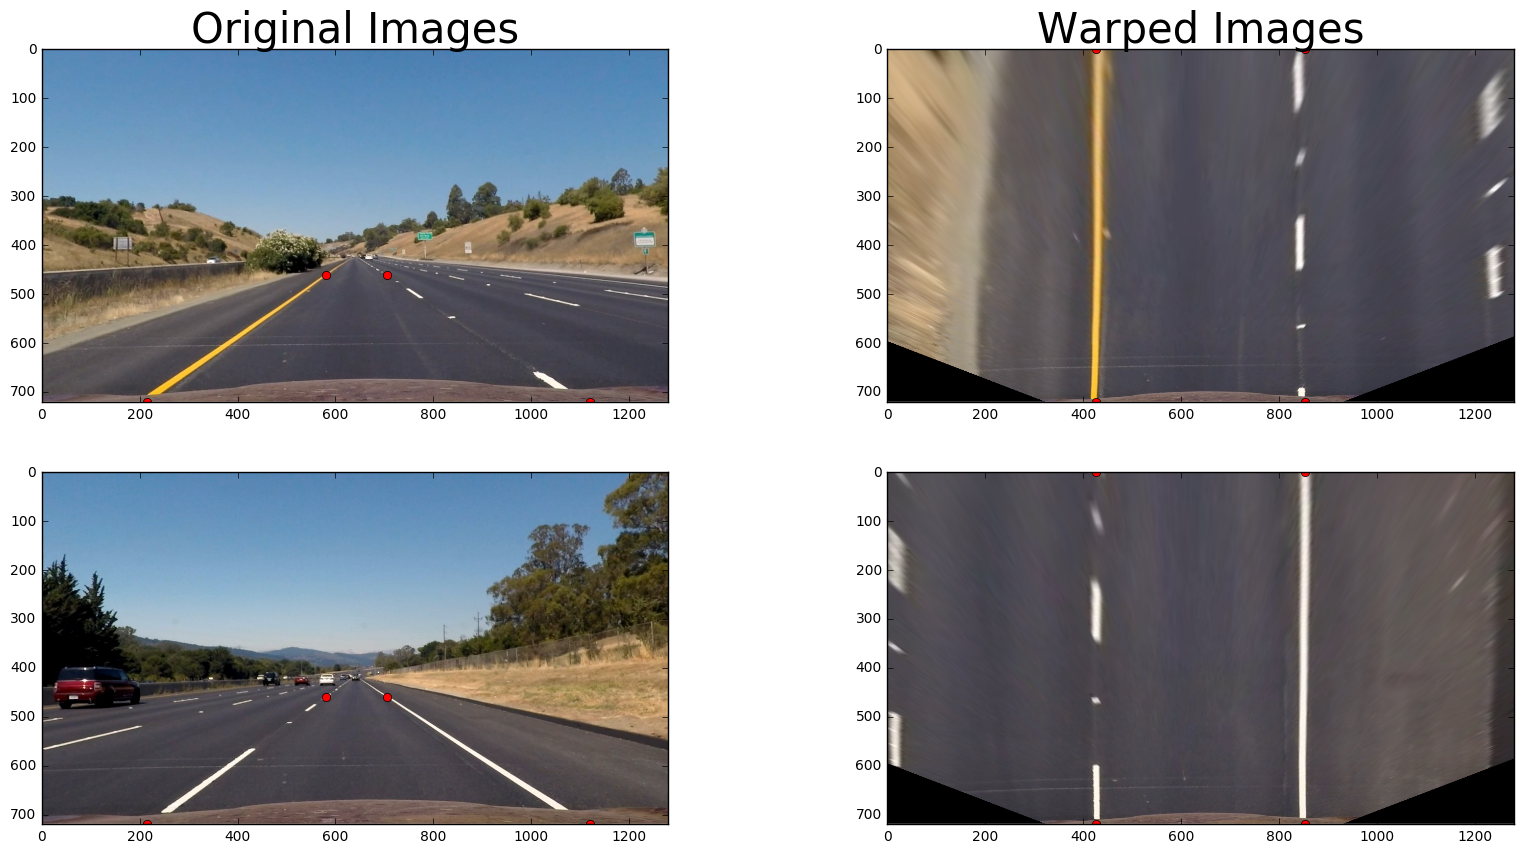

In [4]:
### perspective transform

# read and undistort images for straight road
straight_image_paths = glob.glob("test_images/straight_lines*.jpg")
straight_images = [cv2.imread(path) for path in straight_image_paths]
straight_images = np.array([undistort_image(img) for img in straight_images])

# define source points on original images
src_lower_left = [215, 720]
src_upper_left = [580, 460]
src_upper_right = [705, 460]
src_lower_right = [1120, 720]

# define destination points on warped image
dst_lower_left = [img_width // 3, img_height]
dst_upper_left = [img_width // 3, 0]
dst_upper_right = [img_width * 2 // 3, 0]
dst_lower_right = [img_width * 2 // 3, img_height]

# define shapes for src and dst points
src_pts = np.float32([src_lower_left, src_upper_left, src_upper_right, src_lower_right])
dst_pts = np.float32([dst_lower_left, dst_upper_left, dst_upper_right, dst_lower_right])

# get transform and inverse transform matrices
M = cv2.getPerspectiveTransform(src_pts, dst_pts)
Minv = cv2.getPerspectiveTransform(dst_pts, src_pts)

# define functions to warp and unwarp images, using transform matrices
def warp_image(image):
    warped_image = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
        
    return warped_image

def unwarp_image(image):
    unwarped_image = cv2.warpPerspective(image, Minv, img_size, flags=cv2.INTER_LINEAR)
    
    return unwarped_image

# warp straight images
warped_straight_images = np.uint8([warp_image(img) for img in straight_images])

# plot original and warped images
fig = plt.figure(figsize=(20, 10))

for i in range(2):
    ax1 = fig.add_subplot(2, 2, 2*i+1)
    plt.imshow(straight_images[i,:,:,::-1])
    plt.plot(src_lower_left[0], src_lower_left[1], "ro")
    plt.plot(src_upper_left[0], src_upper_left[1], "ro")
    plt.plot(src_upper_right[0], src_upper_right[1], "ro")
    plt.plot(src_lower_right[0], src_lower_right[1], "ro")
    plt.xlim([0, img_width])
    plt.ylim([img_height, 0])
    
    ax2 = fig.add_subplot(2, 2, 2*i+2)
    plt.imshow(warped_straight_images[i,:,:,::-1])
    plt.plot(dst_lower_left[0], dst_lower_left[1], "ro")
    plt.plot(dst_upper_left[0], dst_upper_left[1], "ro")
    plt.plot(dst_upper_right[0], dst_upper_right[1], "ro")
    plt.plot(dst_lower_right[0], dst_lower_right[1], "ro")
    plt.xlim([0, img_width])
    plt.ylim([img_height, 0])
    
    if i == 0:
        ax1.set_title("Original Images", fontsize=30)
        ax2.set_title("Warped Images", fontsize=30)

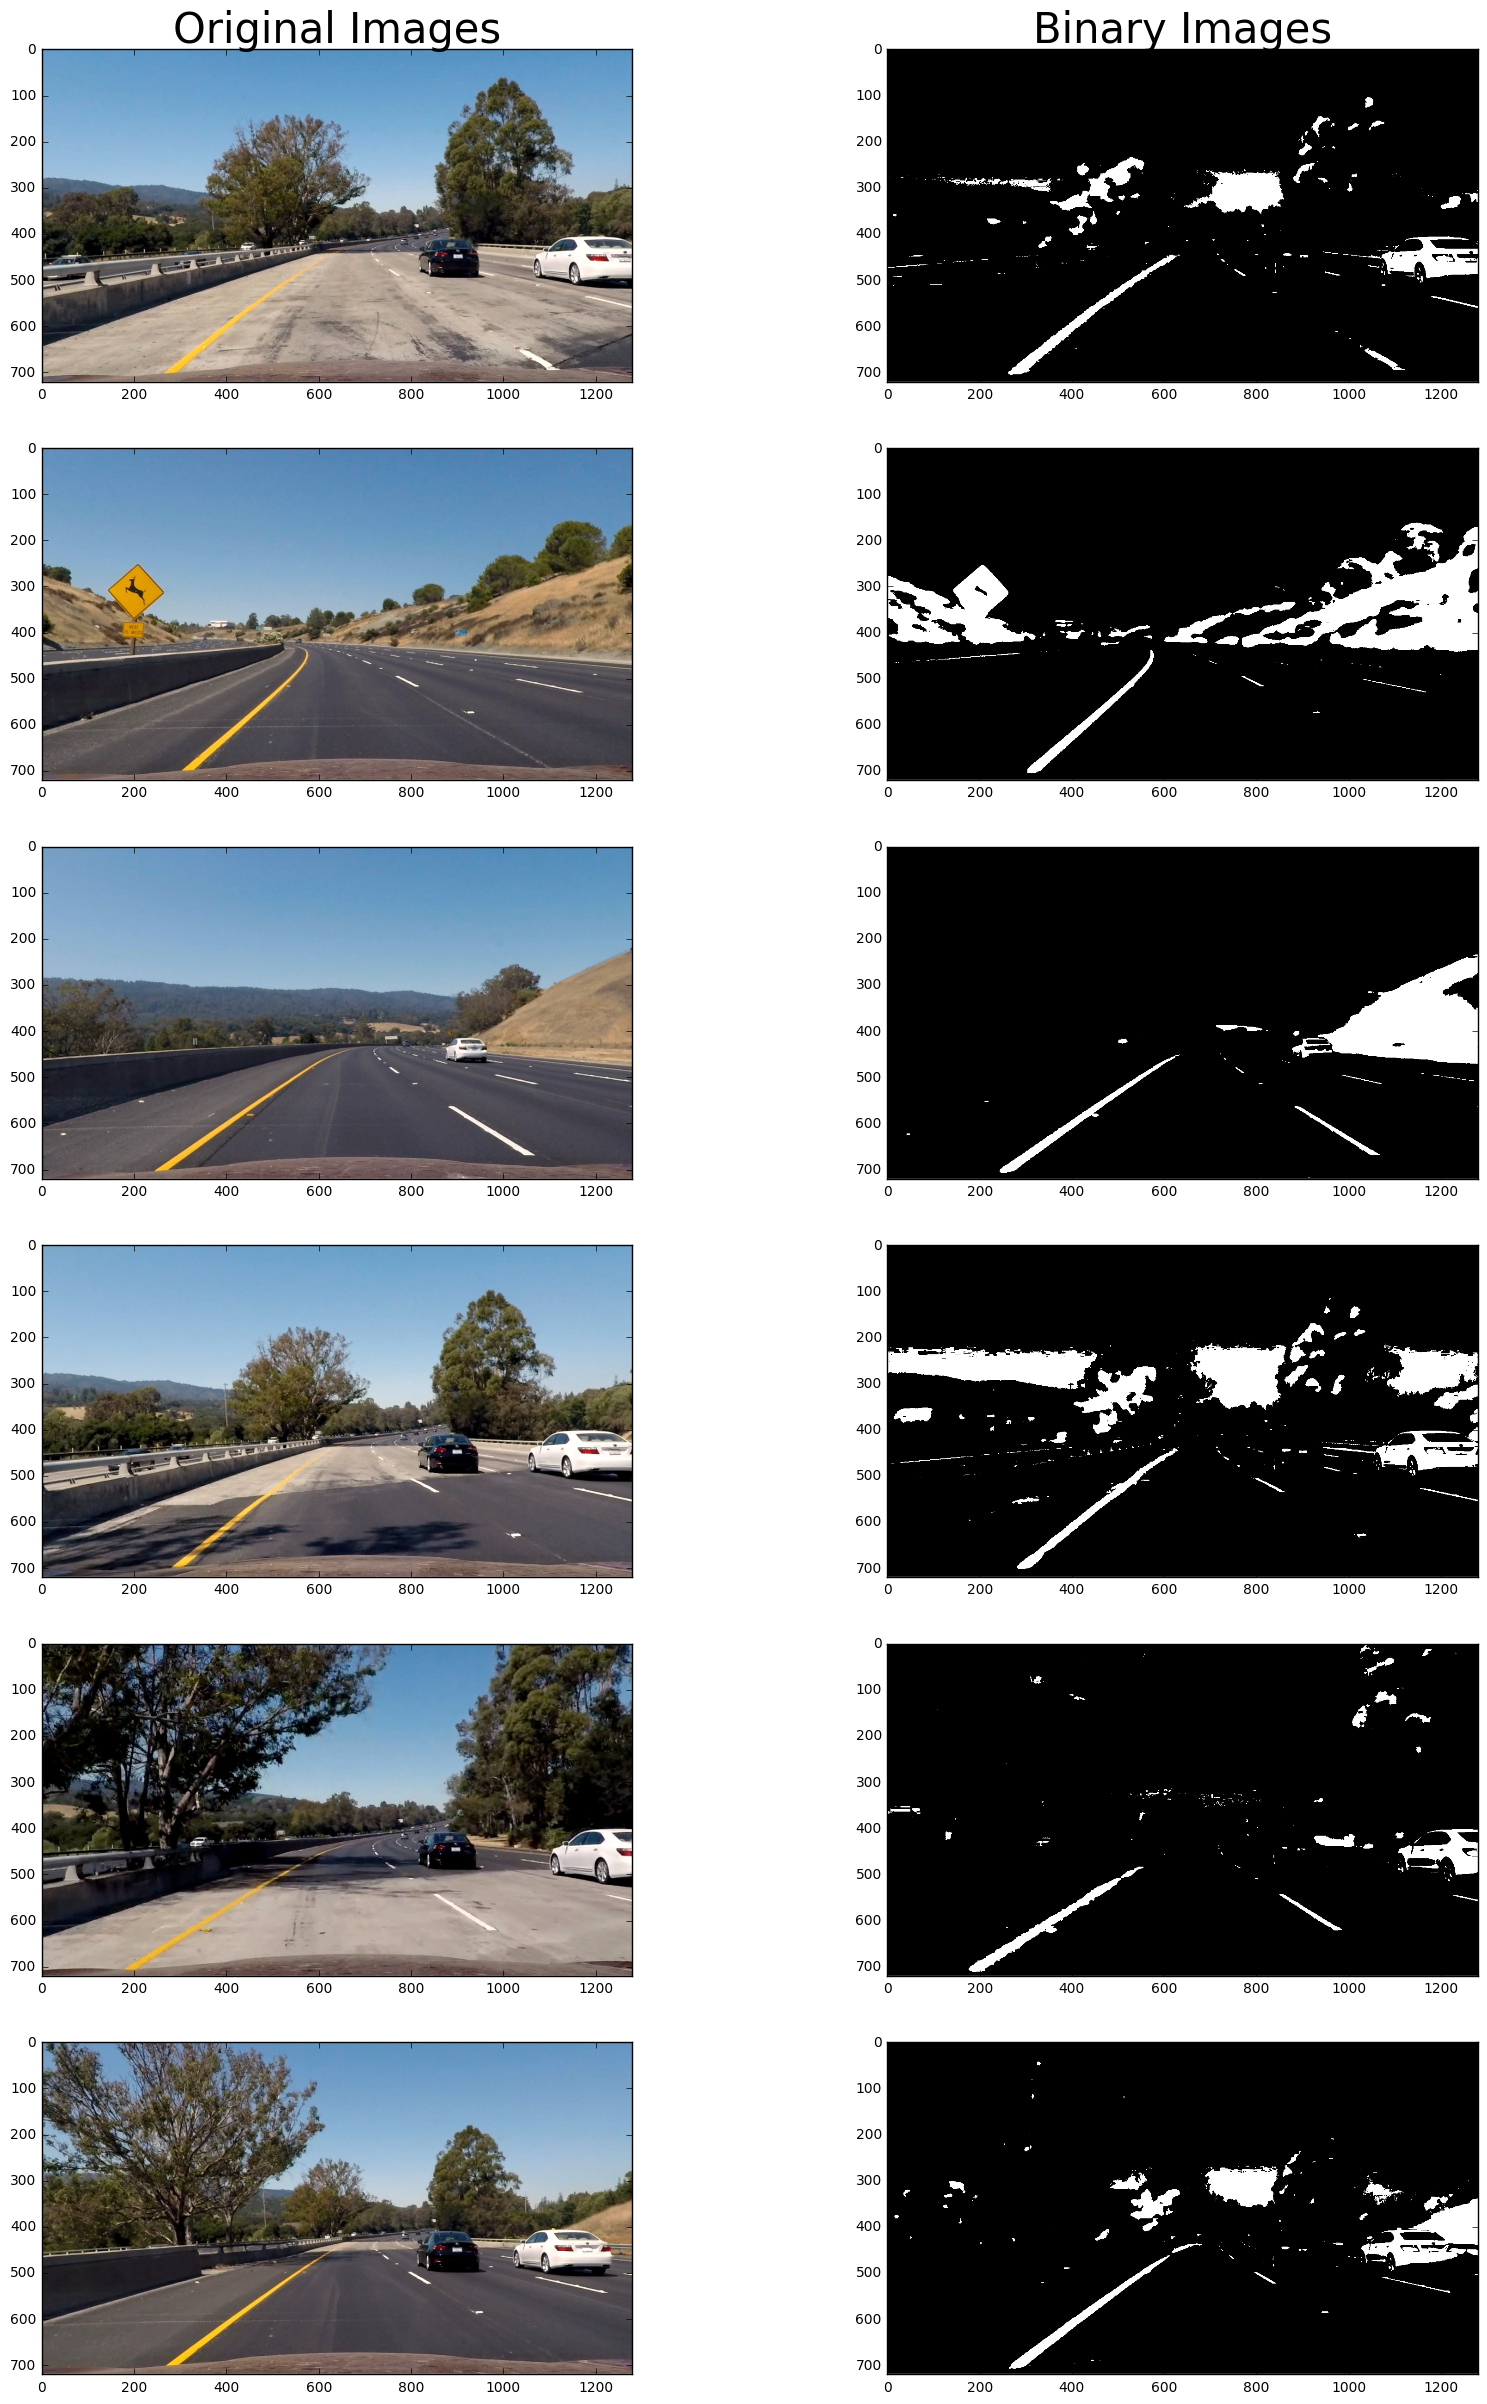

In [5]:
### process images

# read and undistort test images
test_image_paths = glob.glob("test_images/test*.jpg")
test_images = [cv2.imread(path) for path in test_image_paths]
test_images = np.array([undistort_image(img) for img in test_images])

# define function for processing images
def process(image):
    '''
    Takes in a BGR image, converts it to YUV, and uses two thresholds to identify lane lines:
    To find the white lines, it thresholds the Y channel at > 200
    To find the yellow lines, it subtracts the V channel from the U channel, and thresholds the result at > 30
    '''
    
    # convert BGR image to YUV
    yuv_img = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    
    # take individual channels
    y_channel = yuv_img[:,:,0]
    u_channel = yuv_img[:,:,1]
    v_channel = yuv_img[:,:,2]

    # define image, y_binary, that is equal to 1 where y_channel meets the threshold, and 0 elsewhere
    y_binary = np.zeros_like(y_channel)
    y_binary[y_channel > 200] = 1
    
    # find difference between U and V channels
    u_v_diff = u_channel.astype(np.int16) - v_channel.astype(np.int16)
    
    # define image, u_v_diff_binary, that is equal to 1 where u_v_diff meets the threshold, and 0 elsewhere
    u_v_diff_binary = np.zeros_like(u_v_diff)
    u_v_diff_binary[u_v_diff > 30] = 1
    u_v_diff_binary = np.uint8(u_v_diff_binary)
    
    # created combined binary image that is equal to 1 where either condition is met
    combined_binary = np.zeros_like(y_channel)
    combined_binary[((u_v_diff_binary == 1) | (y_binary == 1))] = 1
    
    return combined_binary

processed_images = np.uint8([process(img) for img in test_images])

# plot original and processed images
fig = plt.figure(figsize=(20, 30))

for i in range(6):
    ax1 = fig.add_subplot(6, 2, 2*i+1)
    plt.imshow(test_images[i,:,:,::-1])
    plt.xlim([0, img_width])
    plt.ylim([img_height, 0])
    
    ax2 = fig.add_subplot(6, 2, 2*i+2)
    plt.imshow(processed_images[i], cmap="gray")
    plt.xlim([0, img_width])
    plt.ylim([img_height, 0])
    
    if i == 0:
        ax1.set_title("Original Images", fontsize=30)
        ax2.set_title("Binary Images", fontsize=30)

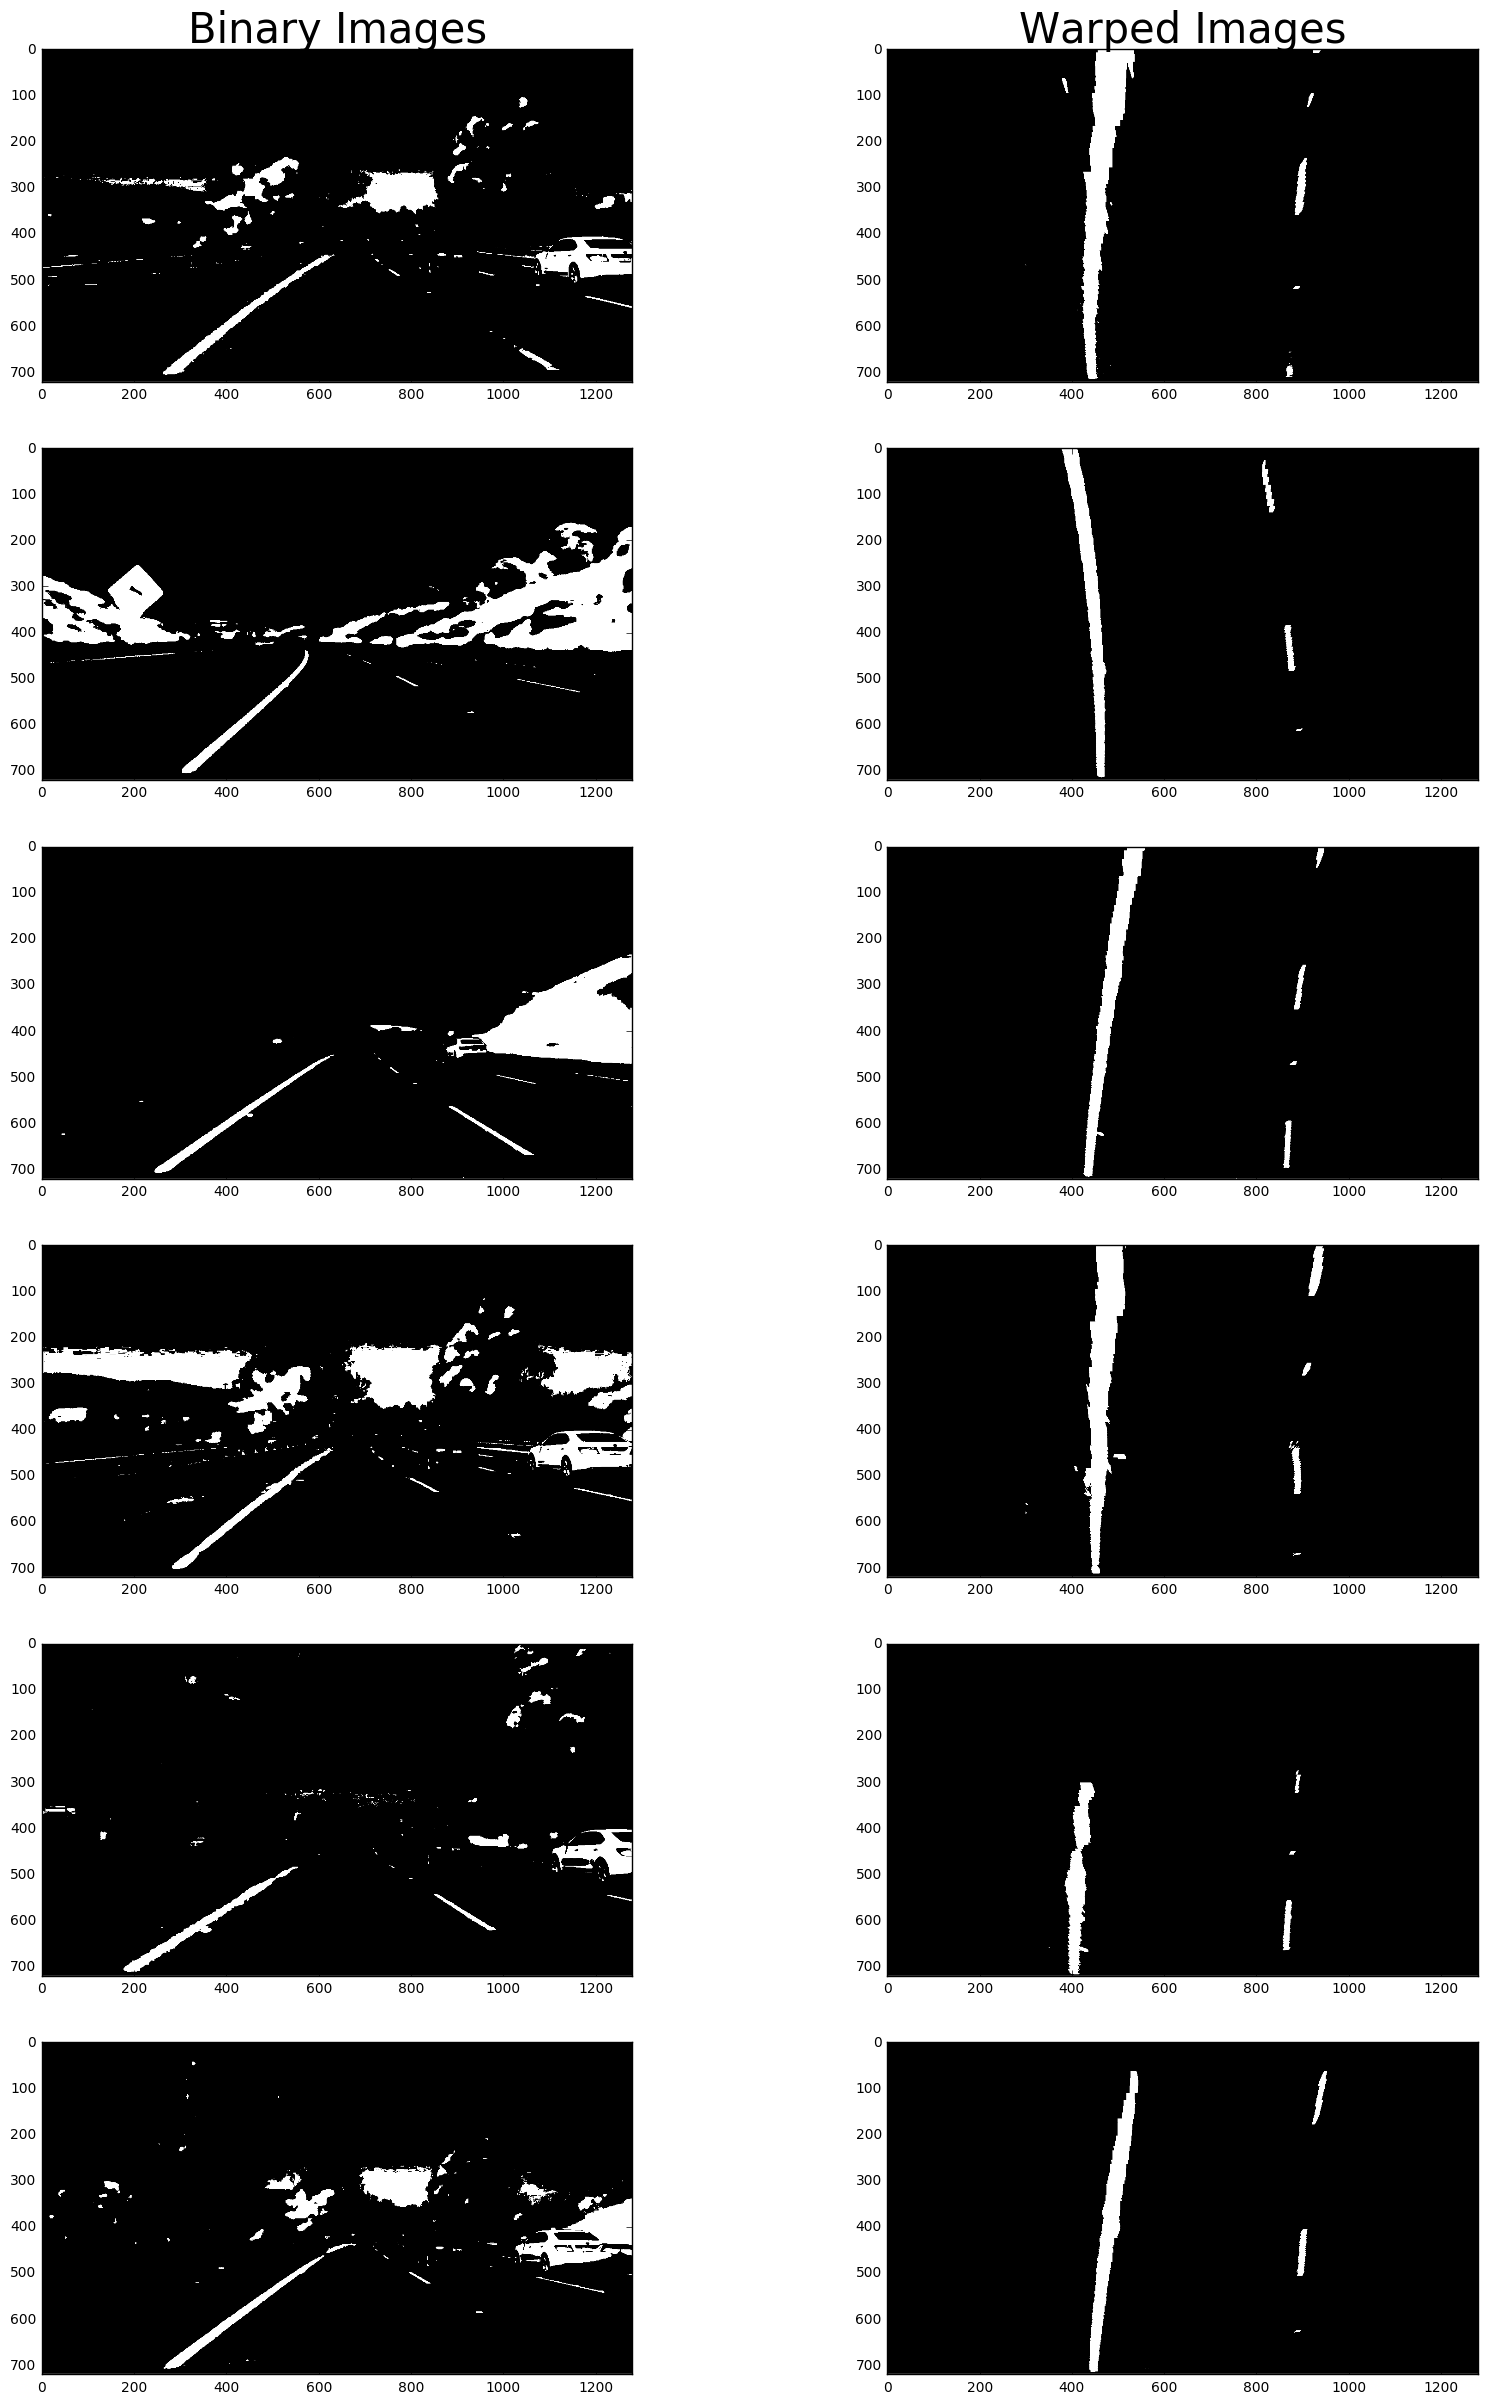

In [6]:
### region mask for warped image
def region_mask(image):
    '''
    Takes and image and makes all pixels near the lateral edges black, to remove noise
    '''
    masked_image = np.copy(image)
    left_margin = 300
    right_margin = 300
    
    masked_image[:,0:left_margin] = 0
    masked_image[:,img_width-right_margin:] = 0
    
    return masked_image

warped_images = np.uint8([warp_image(img) for img in processed_images])
masked_images = np.uint8([region_mask(img) for img in warped_images])

# display binary and warped images
fig = plt.figure(figsize=(20, 30))

for i in range(6):
    ax1 = fig.add_subplot(6, 2, 2*i+1)
    plt.imshow(processed_images[i], cmap="gray")
    plt.xlim([0, img_width])
    plt.ylim([img_height, 0])
    
    ax2 = fig.add_subplot(6, 2, 2*i+2)
    plt.imshow(masked_images[i], cmap="gray")
    plt.xlim([0, img_width])
    plt.ylim([img_height, 0])
    
    if i == 0:
        ax1.set_title("Binary Images", fontsize=30)
        ax2.set_title("Warped Images", fontsize=30)

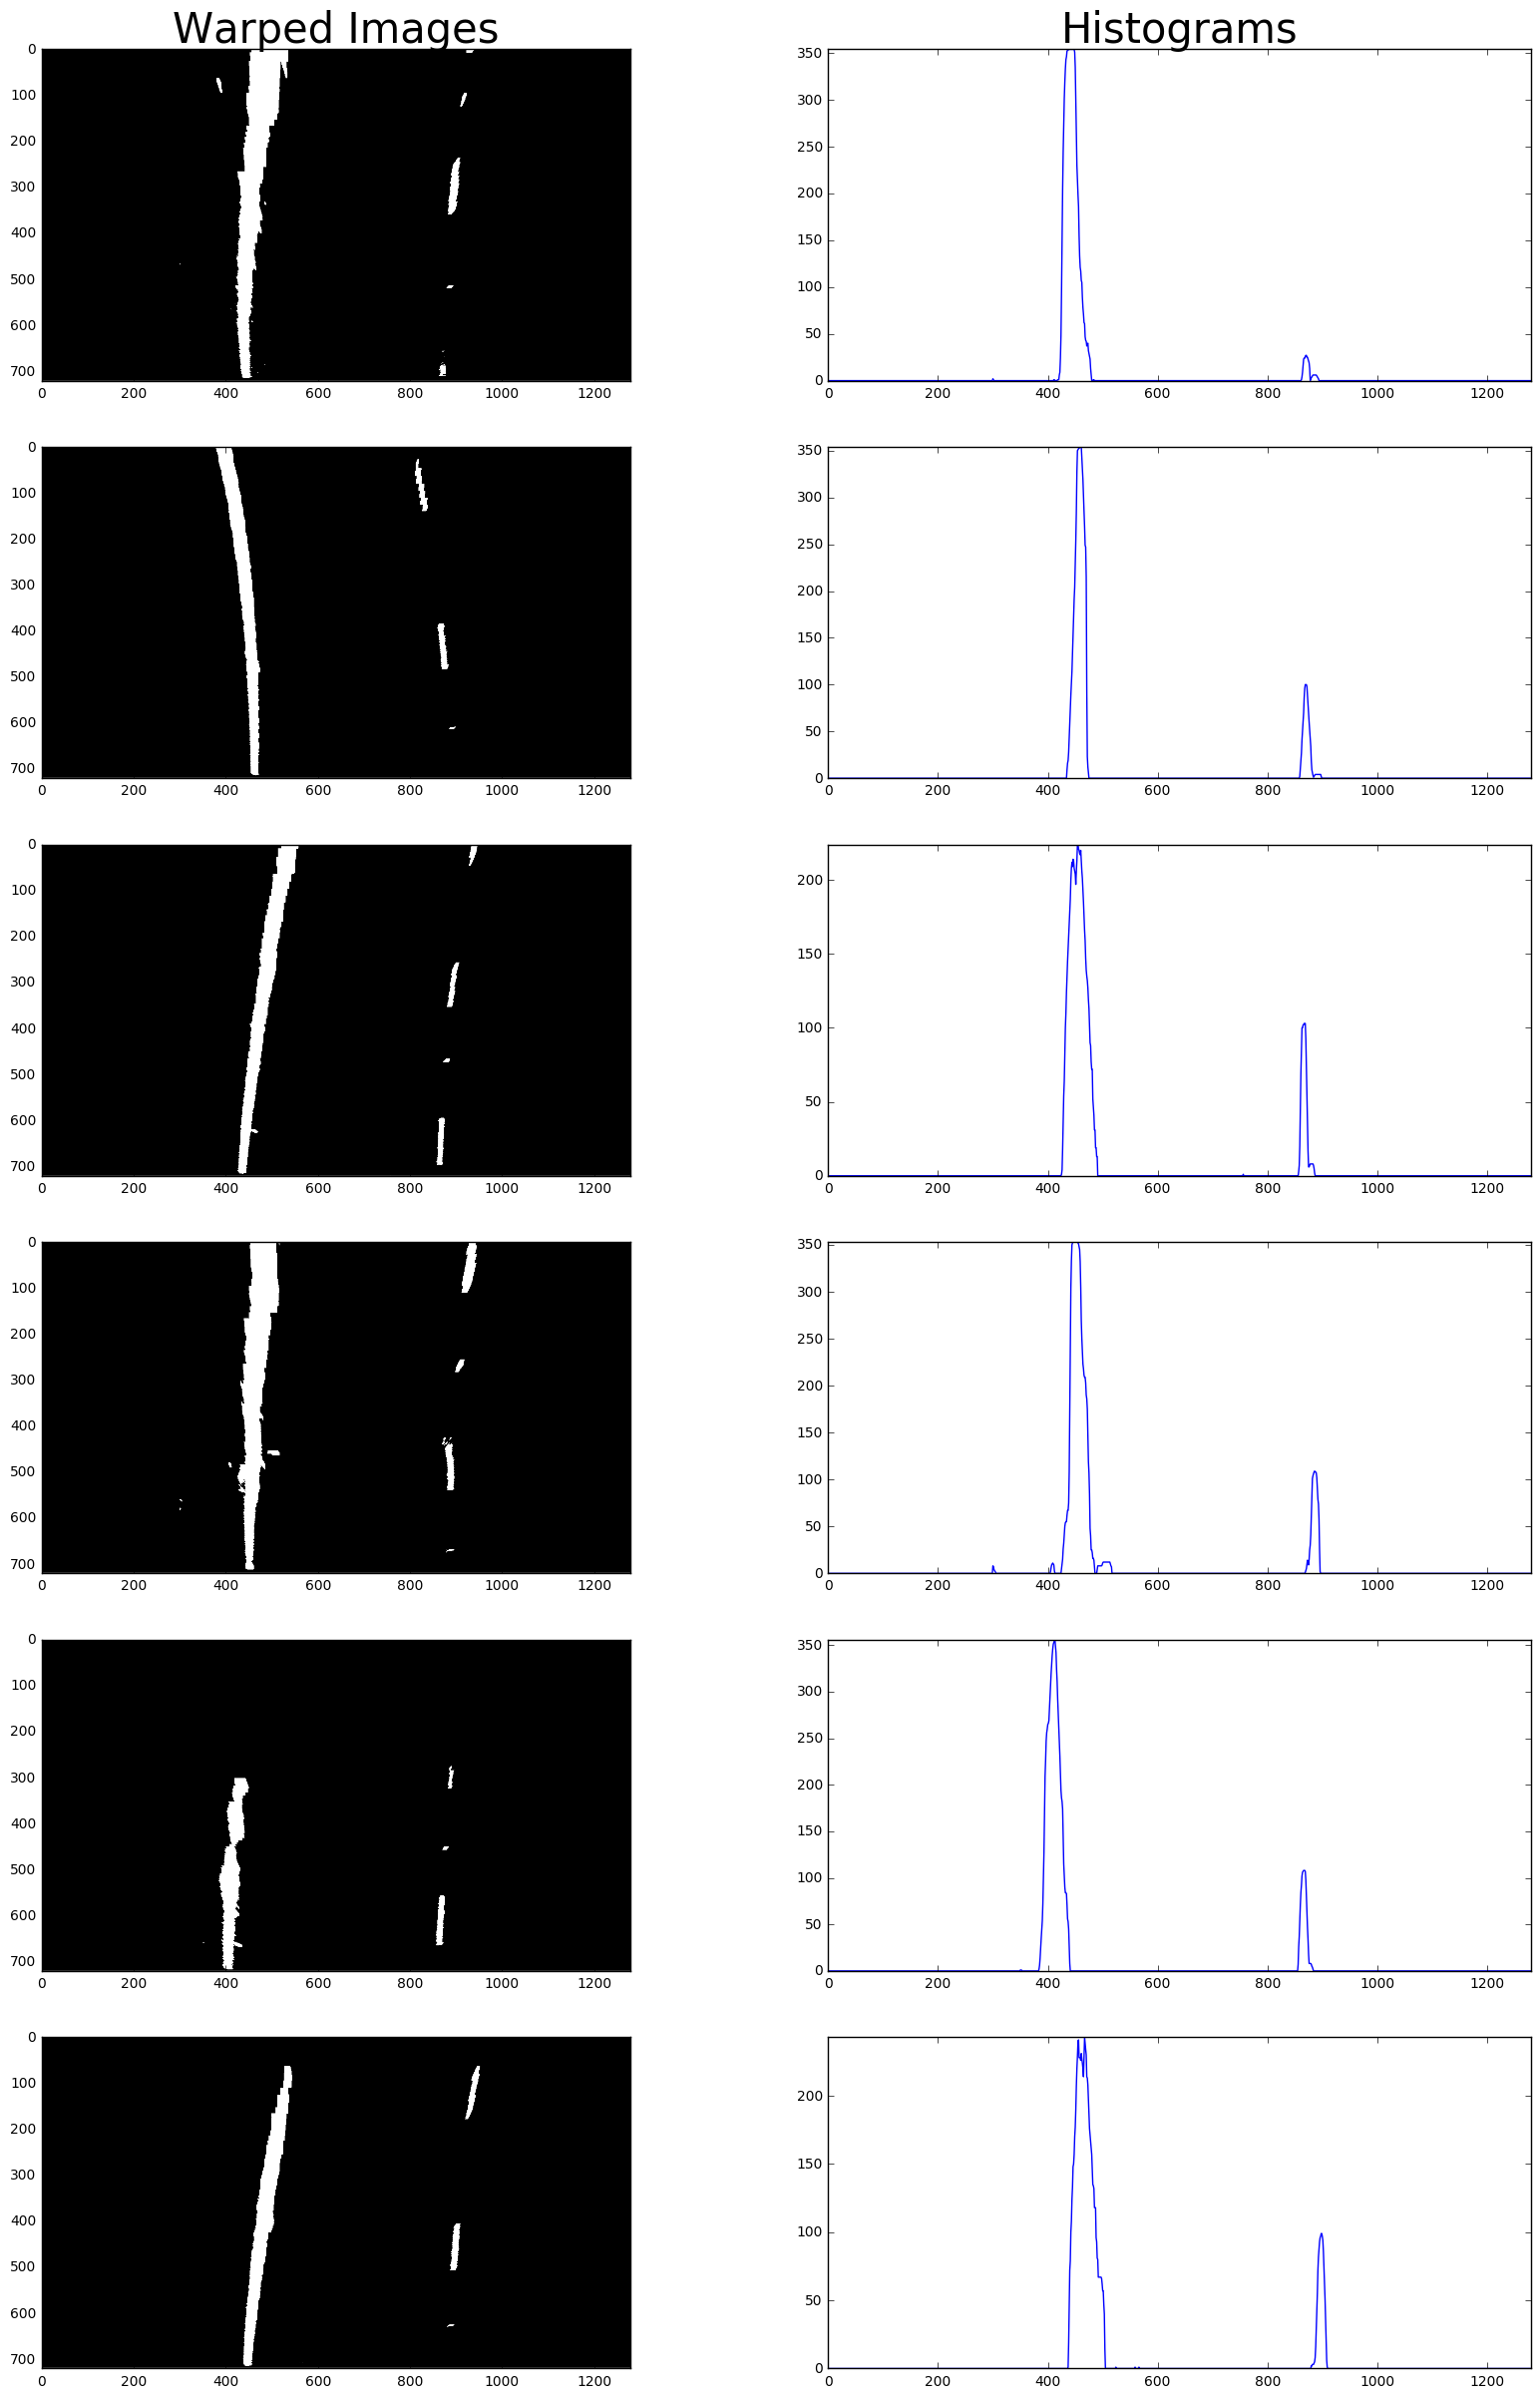

In [7]:
# function to find histogram for columns in lower half of image
def find_histogram(binary_warped):
    histogram = np.sum(binary_warped[img_height // 2:,:], axis=0)
    
    return histogram

# plot warped images and histograms - peaks on histograms correlate with approximate base of lanes
fig = plt.figure(figsize=(20, 30))

for i in range(6):
    ax1 = fig.add_subplot(6, 2, 2*i+1)
    plt.imshow(masked_images[i], cmap="gray")
    plt.xlim([0, img_width])
    plt.ylim([img_height, 0])
    
    ax2 = fig.add_subplot(6, 2, 2*i+2)
    histogram = find_histogram(masked_images[i])
    plt.plot(histogram)
    plt.xlim([0, img_width])
    plt.ylim([0, np.max(histogram)])
    
    if i == 0:
        ax1.set_title("Warped Images", fontsize=30)
        ax2.set_title("Histograms", fontsize=30)

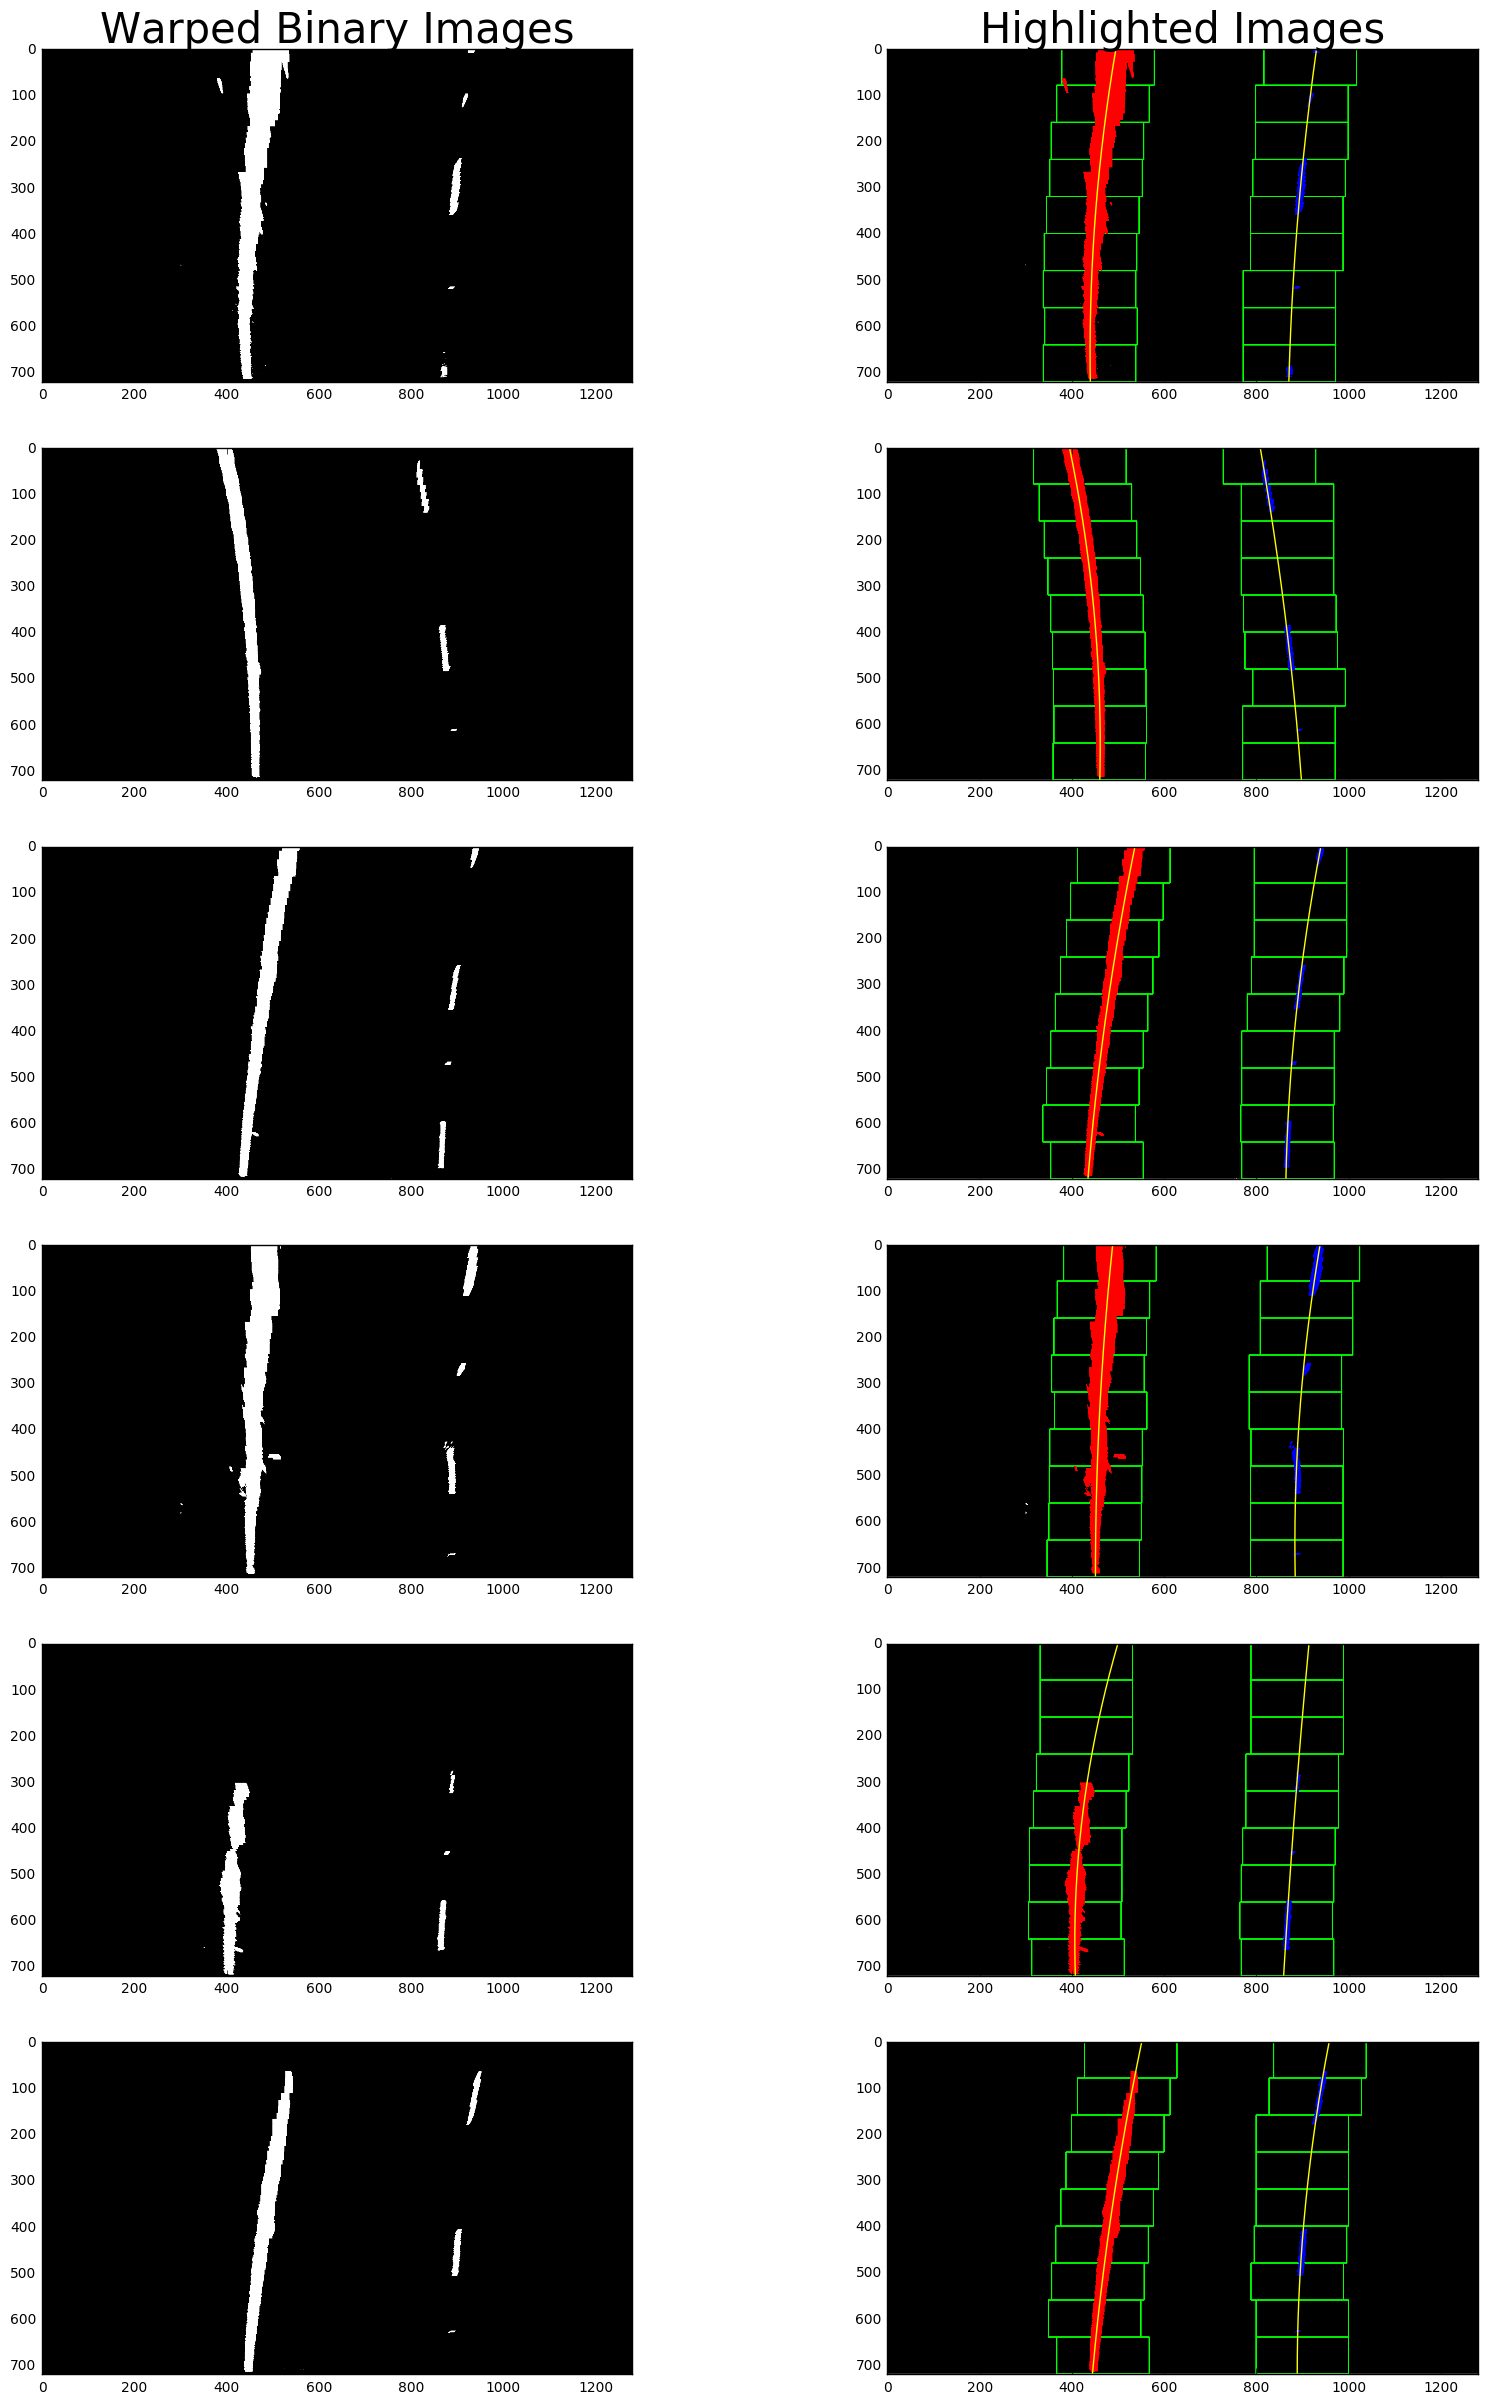

In [8]:
### find the lane lines
def find_lane_lines_windows(binary_warped):
    '''
    function takes in a warped binary image, and finds the points in the
    left and right lanes using a moving windows method
    '''
    # define image to show highlights on lane lines
    highlighted_binary_warped = np.dstack((binary_warped,)*3) * 255
    
    # find histogram peaks to and use those to find the base of the lanes (where to center the first windows)
    histogram = find_histogram(binary_warped)
    left_win_center = np.argmax(histogram[:img_midpoint])
    right_win_center = np.argmax(histogram[img_midpoint:]) + img_midpoint

    # set number of windows and window height
    num_windows = 9
    window_height = img_height // num_windows
    
    # set width of window
    margin = 100
    
    # min number of lane points need to move center of next window 
    minpix = 50
    
    # find indices of all white points
    nonzero = binary_warped.nonzero()
    nonzerox = np.array(nonzero[1])
    nonzeroy = np.array(nonzero[0])
    
    # initialize arrays for points in both lanes
    left_lane_inds = []
    right_lane_inds = []
    
    for win in range(num_windows):
        # define boundaries of windows
        upper_bound = img_height - win * window_height
        lower_bound = upper_bound - window_height
        
        left_lane_left_bound = left_win_center - margin
        left_lane_right_bound = left_win_center + margin
        
        right_lane_left_bound = right_win_center - margin
        right_lane_right_bound = right_win_center + margin
        
        # draw windows
        cv2.rectangle(highlighted_binary_warped,(left_lane_left_bound,lower_bound),(left_lane_right_bound,upper_bound),(0,255,0), 2) 
        cv2.rectangle(highlighted_binary_warped,(right_lane_left_bound,lower_bound),(right_lane_right_bound,upper_bound),(0,255,0), 2) 
        
        # find all indices of points in nonzero arrays that fall within the window
        left_win_inds = ((nonzerox >= left_lane_left_bound)
                            & (nonzerox <= left_lane_right_bound)
                            & (nonzeroy >= lower_bound)
                            & (nonzeroy <= upper_bound)).nonzero()[0]
        
        right_win_inds = ((nonzerox >= right_lane_left_bound)
                            & (nonzerox <= right_lane_right_bound)
                            & (nonzeroy >= lower_bound)
                            & (nonzeroy <= upper_bound)).nonzero()[0]
        
        left_lane_inds.append(left_win_inds)
        right_lane_inds.append(right_win_inds)
        
        # if enough points are found, move the center of the next window to the mean of this one
        if len(left_win_inds) > minpix:
            left_win_center = np.mean(nonzerox[left_win_inds]).astype(np.int)
        if len(right_win_inds) > minpix:
            right_win_center = np.mean(nonzerox[right_win_inds]).astype(np.int)

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # find indices for points in the lanes
    left_lane_x = nonzerox[left_lane_inds]
    left_lane_y = nonzeroy[left_lane_inds]
    
    right_lane_x = nonzerox[right_lane_inds]
    right_lane_y = nonzeroy[right_lane_inds]
    
    # set the color of the left lane to red, and the right lane to blue
    highlighted_binary_warped[left_lane_y, left_lane_x] = [255, 0, 0]
    highlighted_binary_warped[right_lane_y, right_lane_x] = [0, 0, 255]
    
    # fit second order polynomials to lanes in pixels
    left_lane_coeff_px = np.polyfit(left_lane_y, left_lane_x, 2)
    right_lane_coeff_px = np.polyfit(right_lane_y, right_lane_x, 2)
    
    # convert pixel distances and fit second orger polynomials to lanes in meters
    left_lane_coeff_m = np.polyfit(left_lane_y * ym_per_px, left_lane_x * xm_per_px, 2)
    right_lane_coeff_m = np.polyfit(right_lane_y * ym_per_px, right_lane_x * xm_per_px, 2)
    
    return highlighted_binary_warped, left_lane_coeff_px, right_lane_coeff_px, left_lane_coeff_m, right_lane_coeff_m

# plot warped and highlighted images
fig = plt.figure(figsize=(20, 30))

for i in range(6):
    masked_image = masked_images[i]
    
    ax1 = fig.add_subplot(6, 2, 2*i+1)
    plt.imshow(masked_image, cmap="gray")
    
    highlighted_binary_warped, left_lane_coeff_px, right_lane_coeff_px, left_lane_coeff_m, right_lane_coeff_m = find_lane_lines_windows(masked_image)

    plot_y = np.linspace(0, img_height, img_height+1)
    left_plot_x = left_lane_coeff_px[0] * plot_y**2 + left_lane_coeff_px[1] * plot_y + left_lane_coeff_px[2]
    right_plot_x = right_lane_coeff_px[0] * plot_y**2 + right_lane_coeff_px[1] * plot_y + right_lane_coeff_px[2]
    
    ax2 = fig.add_subplot(6, 2, 2*i+2)
    plt.imshow(highlighted_binary_warped)
    plt.plot(left_plot_x, plot_y, color="yellow")
    plt.plot(right_plot_x, plot_y, color="yellow")
    plt.xlim(0, img_width)
    plt.ylim(img_height, 0)
    
    if i == 0:
        ax1.set_title("Warped Binary Images", fontsize=30)
        ax2.set_title("Highlighted Images", fontsize=30)

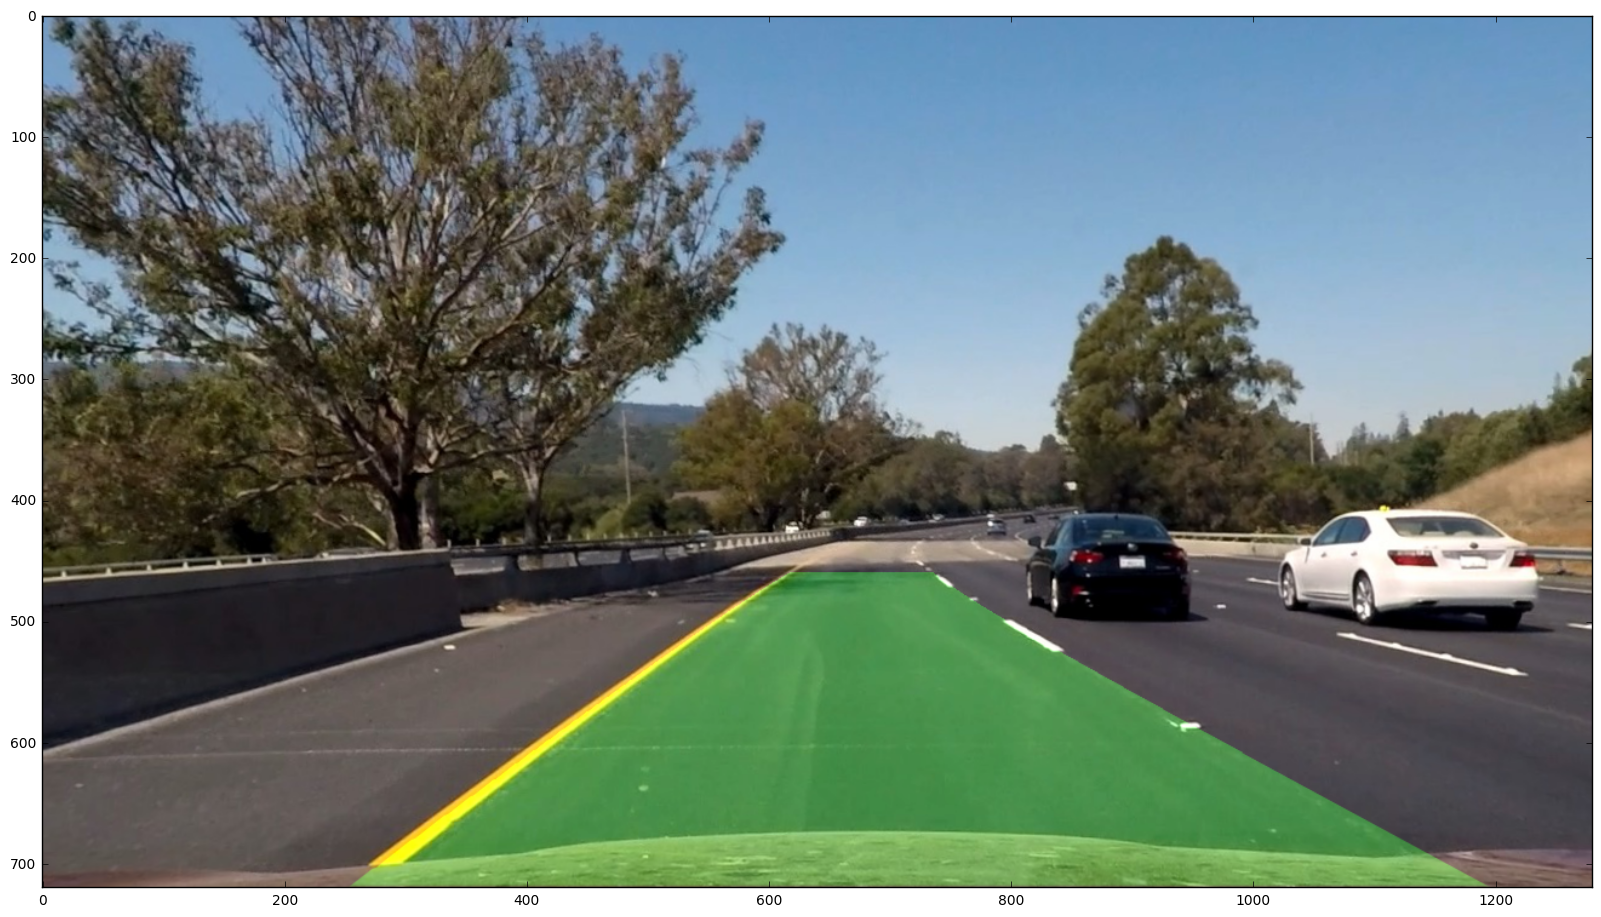

In [9]:
# highlight the lane on the original image
def fill_lane(orig_image, left_lane_coeff_px, right_lane_coeff_px):
    '''
    Takes in an image and the coefficients for the left and right lane polynomials,
    and highlights the lane on the image
    '''
    # blank image
    fill_image = np.zeros_like(orig_image)

    # find points on lane best-fit curves
    plot_y = np.linspace(0, img_height, img_height+1)
    left_plot_x = left_lane_coeff_px[0] * plot_y**2 + left_lane_coeff_px[1] * plot_y + left_lane_coeff_px[2]
    right_plot_x = right_lane_coeff_px[0] * plot_y**2 + right_lane_coeff_px[1] * plot_y + right_lane_coeff_px[2]
    
    # use points to define a polygon to fill in
    left_poly_points = np.vstack((left_plot_x, plot_y)).T
    right_poly_points = np.vstack((right_plot_x, plot_y)).T
    right_poly_points = np.flipud(right_poly_points)
    
    poly_points = np.vstack((left_poly_points, right_poly_points))
    poly_points = np.expand_dims(poly_points, axis=0).astype(np.int_)

    # fill in between the lane curves in green
    cv2.fillPoly(fill_image, poly_points, (0, 255, 0))
    
    # unwarp the filled image
    fill_image = unwarp_image(fill_image)
    
    # overlay the filled lane image on top of the original images
    fill_lane_image = cv2.addWeighted(orig_image, 1, fill_image, 0.3, 0)

    return fill_lane_image

# show filled lane
filled_lane = fill_lane(test_images[5,:,:,::-1], left_lane_coeff_px, right_lane_coeff_px)
fig = plt.figure(figsize=(20, 40))
plt.imshow(filled_lane)

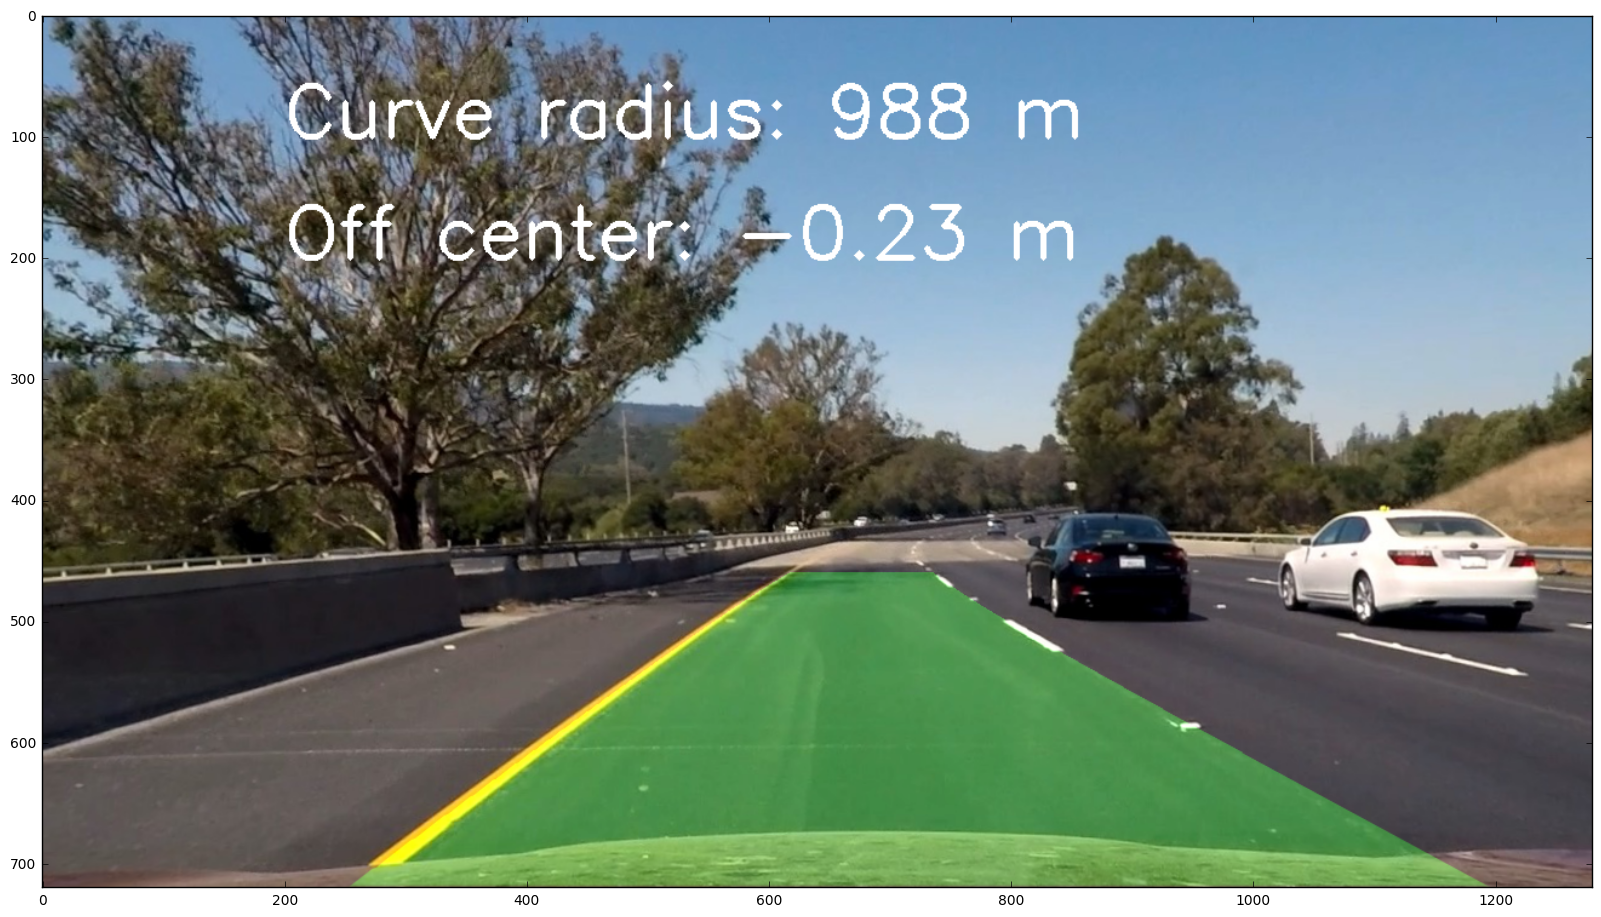

In [10]:
def curve_radius(left_lane_coeff_m, right_lane_coeff_m):
    '''
    Takes in the coefficients for the polynomials of the lane (in meters) and calculates the curve radius of the lane
    '''
    ym = img_height * ym_per_px

    left_curve_rad_m = (1 + (2 * left_lane_coeff_m[0] * ym + left_lane_coeff_m[1])**2)**1.5 / np.absolute(2 * left_lane_coeff_m[0])
    right_curve_rad_m = (1 + (2 * right_lane_coeff_m[0] * ym + right_lane_coeff_m[1])**2)**1.5 / np.absolute(2 * right_lane_coeff_m[0])
    
    curve_radius_m = (left_curve_rad_m + right_curve_rad_m) / 2
    
    return curve_radius_m

def off_center(left_lane_coeff_px, right_lane_coeff_px):
    '''
    Takes in the coefficients for the polynomials for the lanes (in pixels) and calculates how far off center
    the car is
    '''
    y = img_height
    leftx = left_lane_coeff_px[0] * y**2 + left_lane_coeff_px[1] * y + left_lane_coeff_px[2]
    rightx = right_lane_coeff_px[0] * y**2 + right_lane_coeff_px[1] * y + right_lane_coeff_px[2]
    
    lane_midpoint = (leftx + rightx) / 2
    off_center_px = img_midpoint - lane_midpoint
    
    off_center_m = off_center_px * xm_per_px
    
    return off_center_m

def add_stats(image, curve_radius_m, off_center_m):
    '''
    Add the curve radius and off center distance to the image
    '''
    curve_radius_text = "Curve radius: {} m".format(int(curve_radius_m))
    off_center_text = "Off center: {:.2f} m".format(off_center_m)
    
    cv2.putText(image, curve_radius_text, (200,100), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 3)
    cv2.putText(image,off_center_text, (200,200), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 3)
    
    return image

# show image with curve radius and off center distance
radius = curve_radius(left_lane_coeff_m, right_lane_coeff_m)
off_center_pos = off_center(left_lane_coeff_px, right_lane_coeff_px)
text_image = add_stats(filled_lane, radius, off_center_pos)

fig = plt.figure(figsize=(20, 40))
plt.imshow(text_image)

In [11]:
curve_radii = []

### pipeline
def pipeline(image):
    '''
    Pipeline to take in RGB image and go through steps define above
    '''
    # convert rgb to bgr
    bgr_img = image[:,:,::-1]
    
    # undistort image
    undist_image = undistort_image(bgr_img)
    
    # process image
    processed_image = process(undist_image)
    
    # warp image
    warped_image = warp_image(processed_image)
    
    # mask the warped image
    masked_image = region_mask(warped_image)
    
    # find the polynomial coefficients for the best fit curves for the lane lines
    highlighted_binary_warped, left_lane_coeff_px, right_lane_coeff_px, left_lane_coeff_m, right_lane_coeff_m = find_lane_lines_windows(masked_image)
    
    # calculate curve radius
    curve_radius_m = curve_radius(left_lane_coeff_m, right_lane_coeff_m)
    
    # remove outliers, anything else is appended to array
    if curve_radius_m < 5000 and curve_radius_m > 200:
        curve_radii.append(curve_radius_m)
    
    # take moving average of last 20 measurements to smooth out noise in curve radius
    mean_radius = np.mean(curve_radii[-20:])
    
    # calculate off center distance
    off_center_m = off_center(left_lane_coeff_px, right_lane_coeff_px)
    
    # fill lane
    filled_lane = fill_lane(undist_image[:,:,::-1], left_lane_coeff_px, right_lane_coeff_px)
    
    # add stats
    output = add_stats(filled_lane, mean_radius, off_center_m)
    
    return output

In [12]:
output_video = 'output_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
output_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video output_video.mp4
[MoviePy] Writing video output_video.mp4


100%|█████████▉| 1260/1261 [01:33<00:00, 13.78it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video.mp4 

CPU times: user 2min 15s, sys: 12.1 s, total: 2min 27s
Wall time: 1min 34s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('output_video.mp4'))